Version 1.0.0

# Introduction

In this programming assignment we will illustrate a very severe data leakage, that can often be found in competitions, where the pairs of object should be scored, e.g. predict $1$ if two objects belong to the same class and $0$ otherwise. 

The data in this assignment is taken from a real competition, and the funniest thing is that *we will not use training set at all* and achieve almost 100% accuracy score! We will just exploit the leakage.

Now go through the notebook and complete the assignment.

In [55]:
import numpy as np
import pandas as pd 
import scipy.sparse
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 15]

from jupyterthemes import jtplot
jtplot.style(theme='solarizedd')

import tqdm

# Load the data

Let's load the test data. Note, that we don't have any training data here, just test data. Moreover, *we will not even use any features* of test objects. All we need to solve this task is the file with the indices for the pairs, that we need to compare.

Let's load the data with test indices.

In [101]:
test = pd.read_csv('../readonly/data_leakages_data/test_pairs.csv')
test.head(10)

,pairId,FirstId,SecondId
0,0,1427,8053
1,1,17044,7681
2,2,19237,20966
3,3,8005,20765
4,4,16837,599
5,5,3657,12504
6,6,2836,7582
7,7,6136,6111
8,8,23295,9817
9,9,6621,7672


For example, we can think that there is a test dataset of images, and each image is assigned a unique `Id` from $0$ to $N-1$ (N -- is the number of images). In the dataframe from above `FirstId` and `SecondId` point to these `Id`'s and define pairs, that we should compare: e.g. do both images in the pair belong to the same class or not. So, for example for the first row: if images with `Id=1427` and `Id=8053` belong to the same class, we should predict $1$, and $0$ otherwise. 

But in our case we don't really care about the images, and how exactly we compare the images (as long as comparator is binary).  

**We suggest you to try to solve the puzzle yourself first.** You need to submit a `.csv` file with columns `pairId` and `Prediction` to the grader. The number of submissions allowed is made pretty huge to let you explore the data without worries. The returned score should be very close to $1$.

**If you do not want to think much** -- scroll down and follow the instructions below.

In [10]:
test.shape

(368550, 3)

/Users/antelinvestigacionydesarrollo/anaconda3/envs/data/lib/python3.6/site-packages/matplotlib/axis.py:1086: UserWarning: Unable to find pixel distance along axis for interval padding of ticks; assuming no interval padding needed.
  warnings.warn("Unable to find pixel distance along axis "


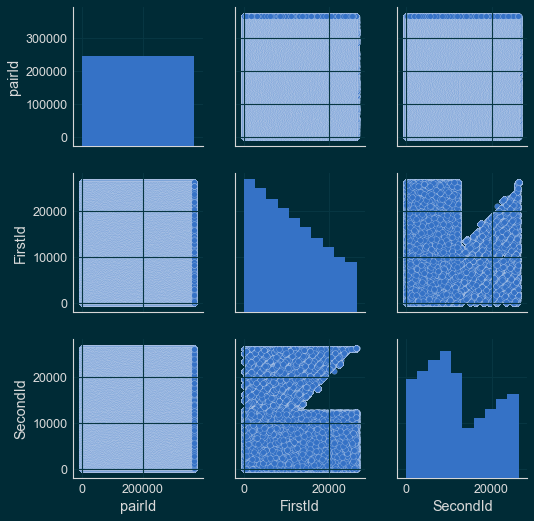

In [9]:
sns.pairplot(test)

The sampling is clearly not uniformly random...

In [18]:
counts1 = test.FirstId.value_counts().sort_values(ascending=False)
counts1

0        21
506      21
1572     21
37       21
293      21
762      21
549      21
805      21
1061     21
1317     21
1573     21
38       21
294      21
552      21
40       21
550      21
1062     21
1318     21
1574     21
250      21
39       21
295      21
551      21
807      21
1063     21
1319     21
296      21
808      21
503      21
554      21
         ..
25991     7
24842     7
25232     7
26000     7
25157     7
25581     7
24711     7
24873     7
25357     7
24587     7
24617     7
25575     7
25125     7
25041     7
25757     7
25174     7
24537     7
25241     7
25598     7
24901     7
24611     7
24333     7
24918     7
24563     7
24565     7
25990     7
25437     7
24535     7
24799     7
24899     7
Name: FirstId, Length: 26325, dtype: int64

In [19]:
counts1.unique()

array([21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10,  9,  8,  7])

So, every value of FirstID is repeated 7 to 21 times.

In [20]:
counts2 = test.SecondId.value_counts().sort_values(ascending=False)
counts2

12194    23
12138    22
12178    22
12112    22
12184    22
12270    22
12145    22
12136    22
12163    22
12192    22
12191    22
12195    22
12231    22
12234    22
12215    22
12146    22
12267    22
12149    22
12251    22
12128    22
12130    22
12245    22
12212    22
12275    22
12207    22
12222    22
12157    22
12160    22
12167    22
12179    22
         ..
26132     2
26138     2
26141     2
26144     2
26130     2
26135     2
26140     2
26136     2
26134     2
26133     2
26143     2
26131     2
26139     2
26137     2
26142     2
26120     1
26118     1
26126     1
26121     1
26117     1
26123     1
26127     1
26125     1
26129     1
26116     1
26124     1
26119     1
26115     1
26128     1
26122     1
Name: SecondId, Length: 26310, dtype: int64

In [21]:
counts2.unique()

array([23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10,  9,  8,  7,
        6,  5,  4,  3,  2,  1])

Every value of SecondID is repeated 1 to 23 times.

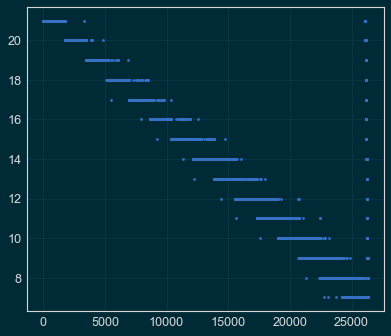

In [24]:
counts1.plot(style='.')

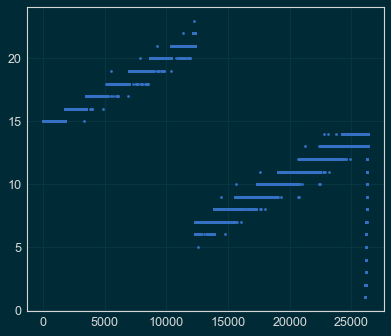

In [25]:
counts2.plot(style='.')

There is a clear pattern, with a cut-out value of about 12500 for SecondID, but I can't still realize what is it.

Text(0,0.5,'FirstID')

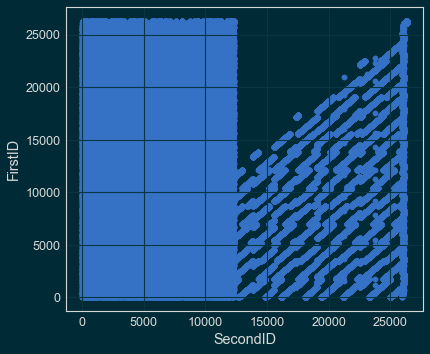

In [28]:
plt.scatter(test.SecondId, test.FirstId)
plt.xlabel('SecondID')
plt.ylabel('FirstID')

It looks like there where 2 sampling procedures. One seems to be relatively uniform, and the other seems to sample in constant i + j values. Clearly, SecondId is greater than FirstId, if SecondID > 12500.

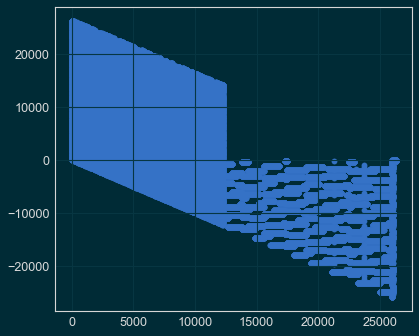

In [31]:
plt.scatter(test.SecondId, test.FirstId - test.SecondId)

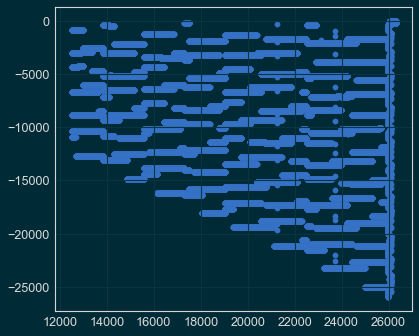

In [32]:
plt.scatter(test.SecondId[test.SecondId>12500], test.FirstId[test.SecondId>12500] - test.SecondId[test.SecondId>12500])

In [34]:
diffs = test.FirstId[test.SecondId>12500] - test.SecondId[test.SecondId>12500]
diffs.nunique()

2640

### Let's create the conectivity matrix

In [35]:
ids1 = test.FirstId.unique()
ids2 = test.FirstId.unique()
print(len(ids1))
print(len(ids2))

26325
26325


In [37]:
(ids1 == ids2).all()

True

That means that the values compared appear all in the 1st and 2nd position.

In [41]:
middle = ids1.shape[0] / 2 # Probably, the switching point
middle

13162.5

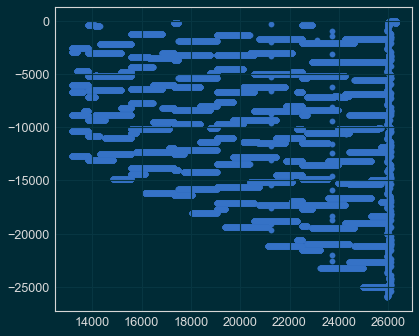

In [42]:
plt.scatter(test.SecondId[test.SecondId>middle], test.FirstId[test.SecondId>middle] - test.SecondId[test.SecondId>middle])

In [46]:
max(ids1)

26324

In [51]:
(sorted(ids1) == np.arange(len(ids1))).all()

True

So, we have all the integers in the range of 0-26325. (last one not included)

In [68]:
n = ids1.shape[0]
M = np.zeros((n, n))
M.shape

(26325, 26325)

In [69]:
test.shape

(368550, 3)

In [70]:
def fill_matrix(M, data):
    for i, row in data.iterrows():
        M[row.FirstId, row.SecondId] = 1
        if i % 10000 == 0:
            print(i / test.shape[0])
    return M

In [71]:
M = fill_matrix(M, test)

0.0
0.0271333604666938
0.0542667209333876
0.0814000814000814
0.1085334418667752
0.135666802333469
0.1628001628001628
0.1899335232668566
0.2170668837335504
0.2442002442002442
0.271333604666938
0.2984669651336318
0.3256003256003256
0.3527336860670194
0.3798670465337132
0.407000407000407
0.4341337674671008
0.4612671279337946
0.4884004884004884
0.5155338488671822
0.542667209333876
0.5698005698005698
0.5969339302672636
0.6240672907339574
0.6512006512006512
0.678334011667345
0.7054673721340388
0.7326007326007326
0.7597340930674265
0.7868674535341202
0.814000814000814
0.8411341744675078
0.8682675349342016
0.8954008954008954
0.9225342558675892
0.949667616334283
0.9768009768009768


In [76]:
n * (n -1)

692979300

In [79]:
test.shape[0] / (n * (n -1))

0.0005318340677708555

There is only a very small percentaje of the possible pairs to predict.

In [80]:
M.sum().sum()

368538.0

In [81]:
test.shape

(368550, 3)

There are only very few repeated pairs (about 12)

In [87]:
sample1 = test[(test.FirstId <=10) & (test.SecondId <=10)]
sample1

,pairId,FirstId,SecondId


In [88]:
sample2 = test[(test.FirstId <=10)]
sample2

,pairId,FirstId,SecondId
935,935,7,5966
1993,1993,3,11797
3276,3276,10,21134
7738,7738,4,5074
8933,8933,2,9678
13828,13828,7,3830
15312,15312,7,24987
15460,15460,1,18059
16819,16819,4,5963
18599,18599,1,4822


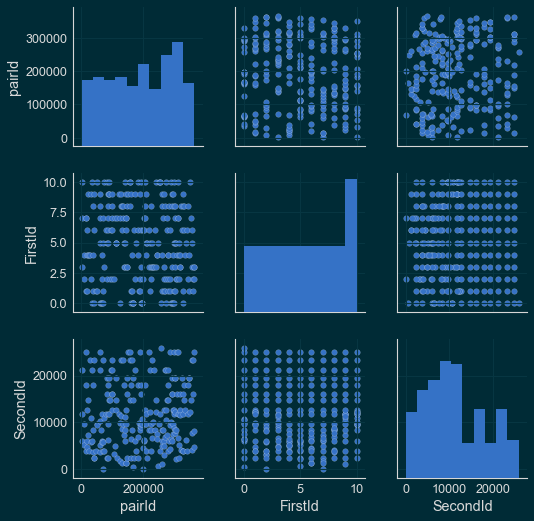

In [90]:
sns.pairplot(sample2)

In [91]:
sample3 = test[(test.FirstId == 0)]
sample3

,pairId,FirstId,SecondId
35134,35134,0,21124
41153,41153,0,2299
61924,61924,0,24980
63873,63873,0,8365
65725,65725,0,5959
68639,68639,0,23254
126418,126418,0,9858
161023,161023,0,6546
165695,165695,0,552
166497,166497,0,19394


In [92]:
sample3.sort_values(by='SecondId')

,pairId,FirstId,SecondId
165695,165695,0,552
41153,41153,0,2299
328931,328931,0,3823
65725,65725,0,5959
289838,289838,0,6453
161023,161023,0,6546
297724,297724,0,7556
63873,63873,0,8365
195980,195980,0,9676
126418,126418,0,9858


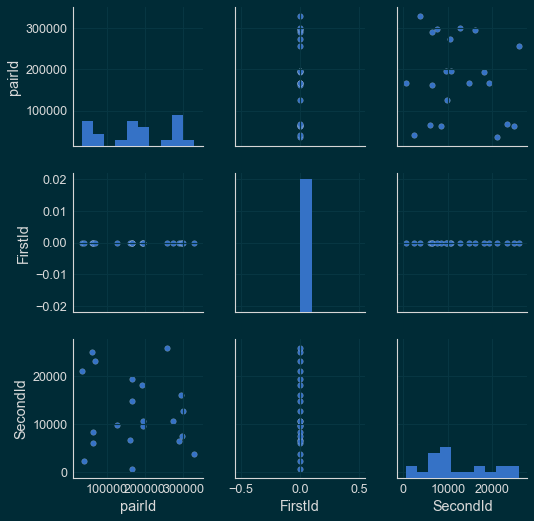

In [94]:
sns.pairplot(sample3)

In [97]:
sample4 = test[(test.SecondId <=10)]
sample4.sort_values('FirstId')

,pairId,FirstId,SecondId
198095,198095,13,7
62024,62024,198,0
46286,46286,413,2
228357,228357,442,6
262224,262224,446,9
367424,367424,554,4
51640,51640,817,3
228751,228751,1066,5
171259,171259,1381,10
344498,344498,1631,1


In [102]:
test['sum_'] = test.FirstId + test.SecondId
test['diff_'] = test.FirstId - test.SecondId
test.head()

,pairId,FirstId,SecondId,sum_,diff_
0,0,1427,8053,9480,-6626
1,1,17044,7681,24725,9363
2,2,19237,20966,40203,-1729
3,3,8005,20765,28770,-12760
4,4,16837,599,17436,16238


In [103]:
test[test.sum_ == 9480]

,pairId,FirstId,SecondId,sum_,diff_
0,0,1427,8053,9480,-6626
46864,46864,2908,6572,9480,-3664
131448,131448,5099,4381,9480,718
152697,152697,3111,6369,9480,-3258
171535,171535,6082,3398,9480,2684
239212,239212,5467,4013,9480,1454
293317,293317,6721,2759,9480,3962
320130,320130,3672,5808,9480,-2136
330350,330350,5536,3944,9480,1592


In [104]:
test[test.diff_ == 9363]

,pairId,FirstId,SecondId,sum_,diff_
1,1,17044,7681,24725,9363
23609,23609,13534,4171,17705,9363
26136,26136,19944,10581,30525,9363
39225,39225,19127,9764,28891,9363
98771,98771,13454,4091,17545,9363
119569,119569,14417,5054,19471,9363
273025,273025,10069,706,10775,9363
301047,301047,17780,8417,26197,9363
306822,306822,13047,3684,16731,9363
310972,310972,15174,5811,20985,9363


In [105]:
test[test.diff_ == 0]

,pairId,FirstId,SecondId,sum_,diff_
186443,186443,300,300,600,0
218927,218927,2551,2551,5102,0
221189,221189,8046,8046,16092,0
228783,228783,2799,2799,5598,0
293834,293834,292,292,584,0
327330,327330,10404,10404,20808,0


In [106]:
test[test.diff_ == 1]

,pairId,FirstId,SecondId,sum_,diff_
62893,62893,7763,7762,15525,1
102796,102796,11804,11803,23607,1
117968,117968,7360,7359,14719,1
120113,120113,7855,7854,15709,1
142234,142234,9080,9079,18159,1
168541,168541,4603,4602,9205,1
242152,242152,10007,10006,20013,1
248928,248928,9994,9993,19987,1
297188,297188,3206,3205,6411,1


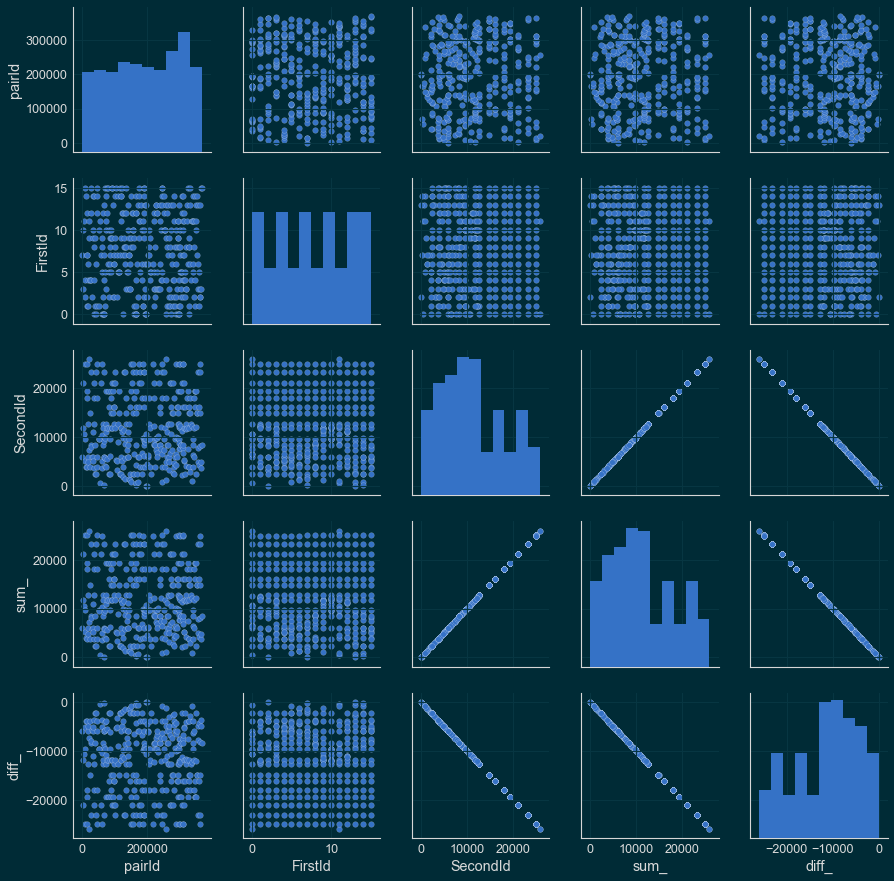

In [107]:
sample5 = test[(test.FirstId <=15)]
sns.pairplot(sample5)

In [110]:
sample5.FirstId.value_counts()

15    21
14    21
13    21
12    21
11    21
10    21
9     21
8     21
7     21
6     21
5     21
4     21
3     21
2     21
1     21
0     21
Name: FirstId, dtype: int64

In [114]:
test[test.FirstId <= middle].FirstId.value_counts()

0        21
1463     21
695      21
823      21
951      21
1079     21
1207     21
1335     21
1591     21
568      21
1719     21
1646     21
56       21
184      21
1518     21
312      21
567      21
439      21
311      21
183      21
55       21
111      21
1718     21
1590     21
1462     21
239      21
1334     21
1206     21
1078     21
367      21
         ..
13068    14
12972    14
13104    14
12830    14
13003    14
12240    14
13054    14
12976    14
12905    14
12812    14
12609    14
12112    14
12649    14
12405    14
12172    14
12204    14
12279    14
12300    14
12332    14
12782    14
12428    14
13131    14
12798    14
12460    14
12556    14
12588    14
12151    14
12716    14
12684    14
12194    13
Name: FirstId, Length: 13163, dtype: int64

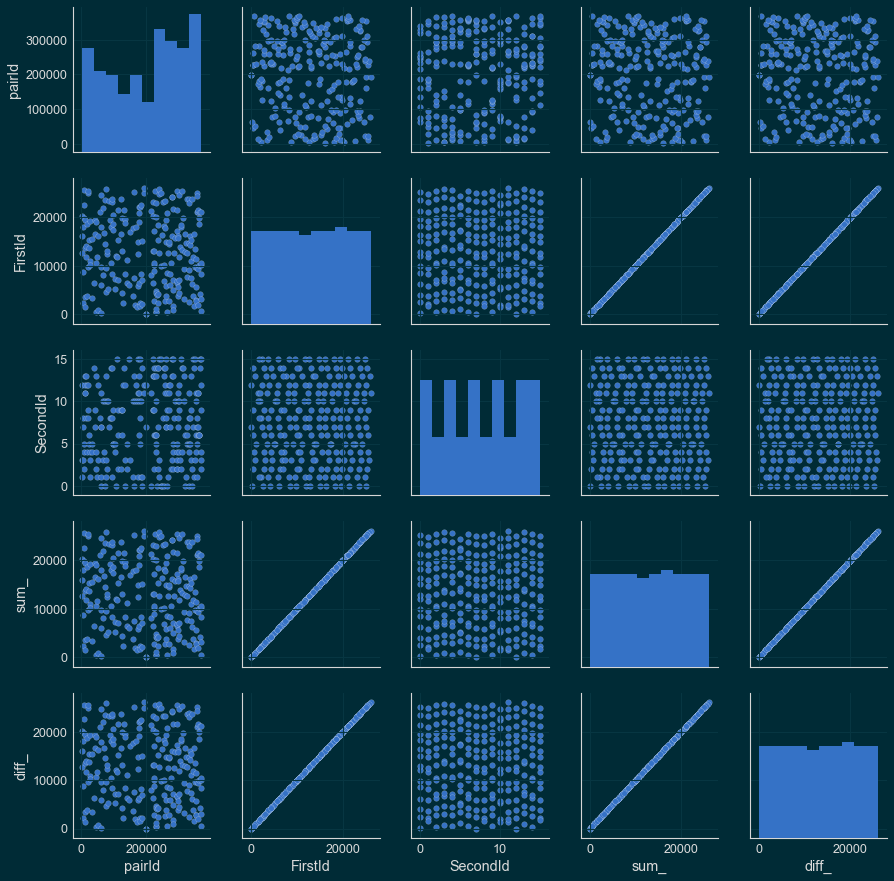

In [115]:
sample6 = test[(test.SecondId <=15)]
sns.pairplot(sample6)

In [121]:
sample6.SecondId.value_counts()

15    15
14    15
13    15
12    15
11    15
10    15
9     15
8     15
7     15
6     15
5     15
4     15
3     15
2     15
1     15
0     15
Name: SecondId, dtype: int64

In [123]:
test = pd.read_csv('../readonly/data_leakages_data/test_pairs.csv')
test.head(10)

,pairId,FirstId,SecondId
0,0,1427,8053
1,1,17044,7681
2,2,19237,20966
3,3,8005,20765
4,4,16837,599
5,5,3657,12504
6,6,2836,7582
7,7,6136,6111
8,8,23295,9817
9,9,6621,7672


# EDA and leakage intuition

As we already know, the key to discover data leakages is careful EDA. So let's start our work with some basic data exploration and build an intuition about the leakage.

First, check, how many different `id`s are there: concatenate `FirstId` and `SecondId` and print the number of unique elements. Also print minimum and maximum value for that vector.

In [125]:
# YOUR CODE GOES HERE
cvec = pd.concat([test.FirstId, test.SecondId])
uvals = cvec.unique()
print(uvals.shape[0])
print(uvals.min())
print(uvals.max())

26325
0
26324


and then print how many pairs we need to classify (it is basically the number of rows in the test set)

In [126]:
# YOUR CODE GOES HERE
print(test.shape[0])

368550


Now print, how many distinct pairs it would be possible to create out of all "images" in the dataset?   

In [127]:
# YOUR CODE GOES HERE
print(uvals.shape[0]**2)

693005625


So the number of pairs we are given to classify is very very small compared to the total number of pairs. 

To exploit the leak we need to **assume (or prove)**, that the total number of positive pairs is small, compared to the total number of pairs. For example: think about an image dataset with $1000$ classes, $N$ images per class. Then if the task was to tell whether a pair of images belongs to the same class or not, we would have $1000\frac{N(N-1)}{2}$ positive pairs, while total number of pairs was $\frac{1000N(1000N - 1)}{2}$.

Another example: in [Quora competitition](https://www.kaggle.com/c/quora-question-pairs) the task was to classify whether a pair of qustions are duplicates of each other or not. Of course, total number of question pairs is very huge, while number of duplicates (positive pairs) is much much smaller.

Finally, let's get a fraction of pairs of class `1`. We just need to submit a constant prediction "all ones" and check the returned accuracy. Create a dataframe with columns `pairId` and `Prediction`, fill it and export it to `.csv` file. Then submit to grader and examine grader's output. 

In [135]:
# YOUR CODE GOES HERE
submission = test.copy().drop(['FirstId', 'SecondId'], axis=1)
submission['Prediction'] = 1
submission.to_csv('submission.csv')
submission.head()

,pairId,Prediction
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1


The result of submitting an all ones prediction is: 

So, we assumed the total number of pairs is much higher than the number of positive pairs, but it is not the case for the test set. It means that the test set is constructed not by sampling random pairs, but with a specific sampling algorithm. Pairs of class `1` are oversampled.

Now think, how we can exploit this fact? What is the leak here? If you get it now, you may try to get to the final answer yourself, othewise you can follow the instructions below.   

# Building a magic feature

In this section we will build a magic feature, that will solve the problem almost perfectly. The instructions will lead you to the correct solution, but please, try to explain the purpose of the steps we do to yourself -- it is very important.

## Incidence matrix

First, we need to build an [incidence matrix](https://en.wikipedia.org/wiki/Incidence_matrix). You can think of pairs `(FirstId, SecondId)` as of edges in an undirected graph. 

The incidence matrix is a matrix of size `(maxId + 1, maxId + 1)`, where each row (column) `i` corresponds `i-th` `Id`. In this matrix we put the value `1` to the position `[i, j]`, if and only if a pair `(i, j)` or `(j, i)` is present in  a given set of pais `(FirstId, SecondId)`. All the other elements in the incidence matrix are zeros.   

**Important!** The incidence matrices are typically very very sparse (small number of non-zero values). At the same time incidence matrices are usually huge in terms of total number of elements, and it is **impossible to store them in memory in dense format**. But due to their sparsity incidence matrices **can be easily represented as sparse matrices**. If you are not familiar with sparse matrices, please see [wiki](https://en.wikipedia.org/wiki/Sparse_matrix) and [scipy.sparse reference](https://docs.scipy.org/doc/scipy/reference/sparse.html). Please, use any of `scipy.sparse` constructors to build incidence matrix. 

For example, you can use this constructor: `scipy.sparse.coo_matrix((data, (i, j)))`. We highly recommend to learn to use different `scipy.sparse` constuctors, and matrices types, but if you feel you don't want to use them, you can always build this matrix with a simple `for` loop. You will need first to create a matrix using `scipy.sparse.coo_matrix((M, N), [dtype])` with an appropriate shape `(M, N)` and then iterate through `(FirstId, SecondId)` pairs and fill corresponding elements in matrix with ones. 

**Note**, that the matrix should be symmetric and consist only of zeros and ones. It is a way to check yourself.

In [ ]:
inc_mat = # YOUR CODE GOES HERE (but probably you will need to write few more lines before)

# Sanity checks
assert inc_mat.max() == 1
assert inc_mat.sum() == 736872

It is convenient to have matrix in `csr` format eventually.

In [ ]:
inc_mat = inc_mat.tocsr()

## Now build the magic feature

Why did we build the incidence matrix? We can think of the rows in this matix as of representations for the objects. `i-th` row is a representation for an object with `Id = i`. Then, to measure similarity between two objects we can measure similarity between their representations. And we will see, that such representations are very good.

Now select the rows from the incidence matrix, that correspond to `test.FirstId`'s, and `test.SecondId`'s.

In [ ]:
# Note, scipy goes crazy if a matrix is indexed with pandas' series. 
# So do not forget to convert `pd.series` to `np.array`
# These lines should normally run very quickly 

rows_FirstId   = # YOUR CODE GOES HERE
rows_SecondId  = # YOUR CODE GOES HERE

Our magic feature will be the *dot product* between representations of a pair of objects. Dot product can be regarded as similarity measure -- for our non-negative representations the dot product is close to 0 when the representations are different, and is huge, when representations are similar. 

Now compute dot product between corresponding rows in `rows_FirstId` and `rows_SecondId` matrices.

In [ ]:
# Note, that in order to do pointwise multiplication in scipy.sparse you need to use function `multiply`
# regular `*` corresponds to matrix-matrix multiplication

f = # YOUR CODE GOES HERE

# Sanity check
assert f.shape == (368550, )

That is it! **We've built our magic feature.** 

# From magic feature to binary predictions

But how do we convert this feature into binary predictions? We do not have a train set to learn a model, but we have a piece of information about test set: the baseline accuracy score that you got, when submitting constant. And we also have a very strong considerations about the data generative process, so probably we will be fine even without a training set. 

We may try to choose a thresold, and set the predictions to 1, if the feature value `f` is higer than the threshold, and 0 otherwise. What threshold would you choose? 

How do we find a right threshold? Let's first examine this feature: print frequencies (or counts) of each value in the feature `f`.

In [ ]:
# For example use `np.unique` function, check for flags

print # YOUR CODE GOES HERE

Do you see how this feature clusters the pairs? Maybe you can guess a good threshold by looking at the values? 

In fact, in other situations it can be not that obvious, but in general to pick a threshold you only need to remember the score of your baseline submission and use this information. Do you understand why and how?  

Choose a threshold below: 

In [ ]:
pred = f > # SET THRESHOLD HERE

# Finally, let's create a submission

In [ ]:
submission = test.loc[:,['pairId']]
submission['Prediction'] = pred.astype(int)

submission.to_csv('submission.csv', index=False)

Now submit it to the grader! It is not possible to submit directly from this notebook, as we need to submit a `csv` file, not a single number (limitation of Coursera platform). 

To download `submission.csv` file that you've just produced <a href='./submission.csv'>click here</a> (if the link opens in browser, right-click on it and shoose "Save link as"). Then go to [assignment page](https://www.coursera.org/learn/competitive-data-science/programming/KsASv/data-leakages/submission) and submit your `.csv` file in 'My submission' tab.


If you did everything right, the score should be very high.

**Finally:** try to explain to yourself, why the whole thing worked out. In fact, there is no magic in this feature, and the idea to use rows in the incidence matrix can be intuitively justified.

# Bonus

Interestingly, it is not the only leak in this dataset. There is another totally different way to get almost 100% accuracy. Try to find it!